In [1]:
import numpy as np
import matplotlib.pyplot as plt

import qutip

%matplotlib inline


In [2]:
n_cutoff    = 15
EJ          = 18     * 2 * np.pi # h GHz
EC          = EJ / 50

computational_states = 2

resonator_states        = 20
resonator_frequency     = 6.02 * 2 * np.pi    

coupling_strength       = 0.130 * 2 * np.pi

In [3]:
# Define the operators
from qutip import charge, Qobj
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh

class Transmon():
    """
    Transmon class. Can possibly be generalized to account for flux_basis and shunted with a junction array.
    """
    def __init__(self, EC, EJ, basis = "charge", n_cutoff = 10):
        # Setup the meta parameters
        self.basis = basis
        self.n_cutoff = n_cutoff
        self.n = self.n_cutoff * 2 + 1

        # Energy of the circuit elements
        self.EC = EC
        self.EJ = EJ

        if self.basis != "charge":
            raise NotImplementedError()
        
        # Get operators
        self.charge, self.cos_flux = self.operators()

        # Define the Hamiltonian
        self.H = self.Hamiltonian(charge_offset = 0, external_flux = 0)

    def lowest_k_eigenstates(self, k = 2):
        H = self.H.data.todense()
        charge_op = self.charge.data.todense()

        vals, vecs = eigsh(H, k = k, which = "SA")

        H_reduced       = Qobj(np.diag(vals))
        charge_overlap  = Qobj(vecs.T.conj() @ charge_op @ vecs)

        return H_reduced, charge_overlap
    
    def Hamiltonian(self, charge_offset = 0, external_flux = 0):
        # Get kinetic and potential term
        if external_flux != 0:
            raise NotImplementedError()
        
        kinetic     = 4 * self.EC * (self.charge - charge_offset) ** 2
        potential   = - self.EJ * self.cos_flux

        return kinetic + potential 


    def operators(self):
        # Define the operators in the flux basis
        charge_op = charge(self.n_cutoff)

        # Define the flux operators
        exp_i_flux = diags(np.ones(self.n - 1), offsets = -1)
        cos_flux   = Qobj((exp_i_flux + exp_i_flux.getH()) / 2)
        
        return charge_op, cos_flux 
    

qubit = Transmon(
    EJ = EJ,
    EC = EC,
    basis = "charge",
    n_cutoff = n_cutoff
)

H_qubit, jump_matrix = qubit.lowest_k_eigenstates(k = computational_states)


In [4]:
omega_qubit     = H_qubit[1, 1] - H_qubit[0, 0]
# anharmonicity   = (H_qubit[2, 2] - H_qubit[1, 1]) - (H_qubit[1, 1] - H_qubit[0, 0])
detuning        = omega_qubit - resonator_frequency

# dispersive_shift_approx = - coupling_strength ** 2 * abs(jump_matrix[0, 1] ** 2)  / detuning * (1 / (1 + detuning / anharmonicity))
dispersive_shift_approx = coupling_strength ** 2 / detuning

print(f"Omega: {omega_qubit / (2 * np.pi)} GHz")
print(f"Resonator frequency: {resonator_frequency / (2 * np.pi)} GHz")
# print(f"Anharmonicity: {anharmonicity / (2 * np.pi)} GHz")
print(f"Dispersive shift: {dispersive_shift_approx / (2 * np.pi)} GHz")

Omega: (6.8190908127540455+0j) GHz
Resonator frequency: 6.02 GHz
Dispersive shift: (0.021149035541723458+0j) GHz


In [5]:
# Define resonator operators
from qutip import destroy
a       = destroy(resonator_states)
a_dag   = a.dag()


In [6]:
from qutip import tensor, identity

I_qubit     = identity(computational_states)
I_resonator = identity(resonator_states)

# Combine to Hamilton
H0 = tensor(H_qubit, I_resonator) + resonator_frequency * tensor(I_qubit, a * a_dag)
H1 = coupling_strength * tensor(jump_matrix, a + a_dag)


def get_hamiltonian(driving_frequency, driving_amplitude = 0.025):
    driving = lambda t, args: driving_amplitude * np.cos(driving_frequency * t)

    H_driving_term = 2j * tensor(I_qubit, a_dag - a)
    H_driving = [H_driving_term, driving]

    return H_driving

In [7]:
# Do the initial states
from qutip import fock_dm, basis

ground_state_density_matrix     = basis([computational_states, resonator_states], [0, 0])
excited_state_density_matrix    = basis([computational_states, resonator_states], [1, 0])
# second_state_density_matrix     = basis([computational_states, resonator_states], [2, 0])

initial_states = [ground_state_density_matrix, excited_state_density_matrix] #, second_state_density_matrix]

In [8]:
# The frequencies to scan
driving_frequencies_to_scan = resonator_frequency + np.linspace(-3, 3, 101) * dispersive_shift_approx

In [9]:
# Do the simulations
from qutip import mesolve
from tqdm import tqdm

tlist = np.linspace(0, 100, 2001)

results = {0: [], 1: []}

for driving_frequency in tqdm(driving_frequencies_to_scan):
    H_driving = get_hamiltonian(driving_frequency)
    H = [H0, H1, H_driving]

    for i in range(len(initial_states)):
        result = mesolve(H, initial_states[i], tlist)
        results[i].append(result.states[-1].ptrace(1))

100%|██████████| 101/101 [09:50<00:00,  5.84s/it]


/home/johannseverin/anaconda3/envs/qi/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


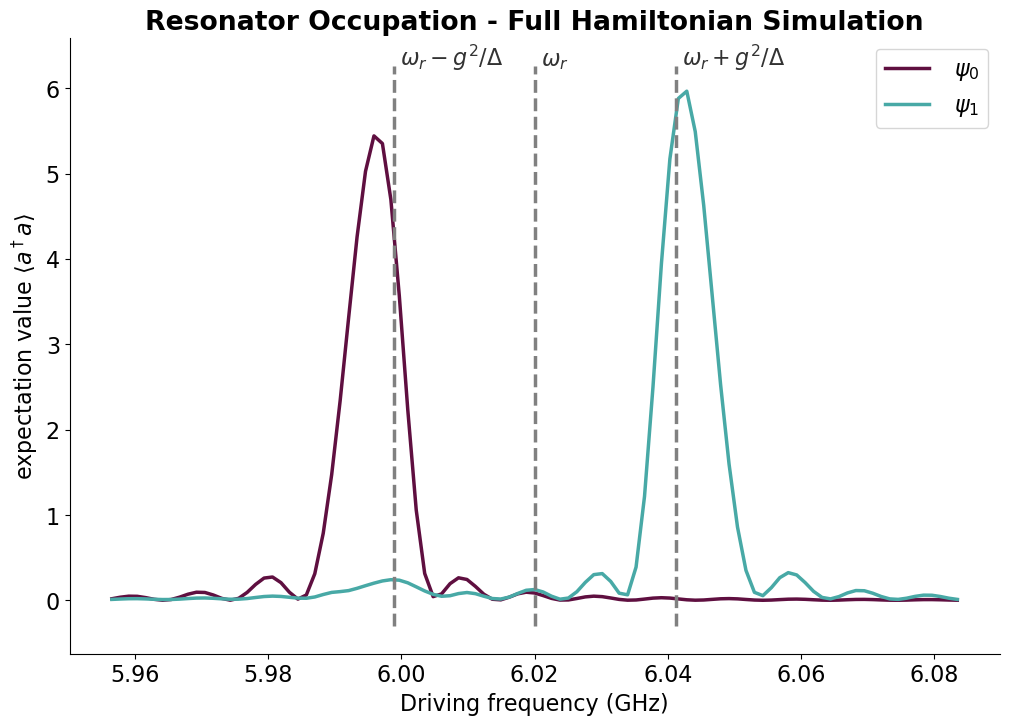

In [11]:
plt.style.use("../matplotlib_style/standard_plot_style.mplstyle")

fig, ax = plt.subplots()

for key in results.keys():
    ax.plot(driving_frequencies_to_scan / (2 * np.pi), qutip.expect(a_dag * a, results[key]).real, label = " $\psi_{}$".format(key))


limits = ax.get_ylim()

omega_r = resonator_frequency / (2 * np.pi)
omega_r_plus = (resonator_frequency + dispersive_shift_approx.real) / (2 * np.pi)
omega_r_minus = (resonator_frequency - dispersive_shift_approx.real) / (2 * np.pi)

ax.vlines(omega_r, *limits, linestyles = "dashed", color = "gray")
ax.text(omega_r + .001, limits[1], "$\omega_r$", alpha = 0.8)

ax.vlines(omega_r_plus, *limits, linestyles = "dashed", color = "gray")
ax.text(omega_r_plus + .001, limits[1], "$\omega_r + g^2/\Delta$", alpha = 0.8)

ax.vlines(omega_r_minus, *limits, linestyles = "dashed", color = "gray")
ax.text(omega_r_minus + .001, limits[1], "$\omega_r - g^2/\Delta$", alpha = 0.8)

# ax.vlines((resonator_frequency - dispersive_shift_approx) / (2 * np.pi), *limits, linestyles = "dashed", color = "gray")


ax.legend()
ax.set(
    title = "Resonator Occupation - Full Hamiltonian Simulation",
    xlabel = "Driving frequency (GHz)",
    ylabel = "expectation value $\\langle a^\\dagger a \\rangle$"
);